In [1]:
%matplotlib inline
import os
import sys
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms, datasets
from torch.utils.data import ConcatDataset
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchmetrics import Accuracy
from torchinfo import summary

from torch.utils.tensorboard import SummaryWriter
from Lenet import LeNet5

import matplotlib.pyplot as plt
import numpy as np

# Settings 

torch.set_printoptions(precision=3)

In [2]:
BATCH_SIZE = 64

### First we train Lenet model on MNIST data set tath includes digits from 1 to 9, Secondly, we use pre-trained model to and fine tune it to classify '0' 

In [3]:
class MNISTNoZero(datasets.MNIST):
    def __init__(self, *args, **kwargs):
        super(MNISTNoZero, self).__init__(*args, **kwargs)
        
        # Filter out indices of all '0' digits
        self.non_zero_indices = [i for i, target in enumerate(self.targets) if target != 0]
        
        # Keep only the data and targets that are not '0'
        self.data = self.data[self.non_zero_indices]
        self.targets = self.targets[self.non_zero_indices] - 1


# Normalization transform
transform_normalize = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

#Use to get the '0' digits
mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform_normalize)

# Create training and test datasets without '0' digits
mnist_trainset_no_zero = MNISTNoZero(root='./data', train=True, download=True, transform=transform_normalize)

mnist_testset_no_zero = MNISTNoZero(root='./data', train=False, download=True, transform=transform_normalize)
classes = ('1', '2', '3', '4', '5', '6', '7', '8', '9')


# Verify by checking the unique labels in the modified datasets
print("Unique labels in the modified training set:", mnist_trainset_no_zero.targets.unique())
print("Unique labels in the modified test set:", mnist_testset_no_zero.targets.unique())



Unique labels in the modified training set: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8])
Unique labels in the modified test set: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8])


In [4]:
# size of mnist_trainset_no_zero
print("Size of the modified training set:", len(mnist_trainset_no_zero))

Size of the modified training set: 54077


In [5]:
indices_of_zeros = [i for i, label in enumerate(mnist_dataset.targets) if label == 0]

# Randomly select 100-200 indices of '0' digits
# You can adjust the number by changing the value of num_samples
num_samples = 100  # or 200, depending on your requirement
selected_indices = np.random.choice(indices_of_zeros, num_samples, replace=False)

# Create a subset from the MNIST dataset using the selected indices
subset_of_zeros = torch.utils.data.Subset(mnist_dataset, selected_indices)

# Verify the dataset
print(f"Number of images in the subset: {len(subset_of_zeros)}")


Number of images in the subset: 100


In [6]:
train_dataset, val_dataset = torch.utils.data.random_split(mnist_trainset_no_zero, [45077, 9000])

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=64,
                                          shuffle=True, num_workers=0)

# good
testloader = torch.utils.data.DataLoader(mnist_testset_no_zero, batch_size=64,
                                            shuffle=False, num_workers=0)

valloader = torch.utils.data.DataLoader(val_dataset, batch_size=64,
                                            shuffle=False, num_workers=0)

# good
zero_loader = torch.utils.data.DataLoader(subset_of_zeros, batch_size=10,  # Smaller batch size due to small dataset
                                          shuffle=True, num_workers=2)

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [7]:
accuracy = Accuracy(task='multiclass', num_classes=9)

accuracy = accuracy.to(device)
model_lenet = LeNet5(num_classes=9).to(device)

criterion = nn.CrossEntropyLoss()
optimizer_adam = optim.Adam(model_lenet.parameters(), lr=1e-4)

optimizer_sgd = torch.optim.SGD(model_lenet.parameters(), lr=0.001, momentum=0.9)

In [8]:
summary(model=model_lenet, input_size=(1, 1, 28, 28), col_width=17,
                  col_names=['input_size', 'output_size', 'num_params', 'trainable'], row_settings=['var_names'], verbose=0)

Layer (type (var_name))                  Input Shape       Output Shape      Param #           Trainable
LeNet5 (LeNet5)                          [1, 1, 28, 28]    [1, 9]            --                True
├─Sequential (feature)                   [1, 1, 28, 28]    [1, 16, 5, 5]     --                True
│    └─Conv2d (0)                        [1, 1, 28, 28]    [1, 6, 28, 28]    156               True
│    └─Tanh (1)                          [1, 6, 28, 28]    [1, 6, 28, 28]    --                --
│    └─AvgPool2d (2)                     [1, 6, 28, 28]    [1, 6, 14, 14]    --                --
│    └─Conv2d (3)                        [1, 6, 14, 14]    [1, 16, 10, 10]   2,416             True
│    └─Tanh (4)                          [1, 16, 10, 10]   [1, 16, 10, 10]   --                --
│    └─AvgPool2d (5)                     [1, 16, 10, 10]   [1, 16, 5, 5]     --                --
├─Sequential (classifier)                [1, 16, 5, 5]     [1, 9]            --                True
│  

In [9]:
# Track the loss and accuracy
timestamp = datetime.now().strftime("%Y-%m-%d")
experiment_name = f'LeNet_One_to_Nine_{timestamp}'
model_name = 'LeNet_v2'
log_dir = os.path.join('runs', timestamp, experiment_name, model_name)
log_writer = SummaryWriter(log_dir=log_dir)

In [10]:
for epoch in range(15):  # loop over the dataset multiple times
    train_loss, train_acc = 0, 0
    cumulative_batch = 0

    print(f'Epoch {epoch+1}')
    for X, y in trainloader:
        
        model_lenet.train()
        X, y = X.to(device), y.to(device)

        cumulative_batch += BATCH_SIZE
        print(f'Batch {cumulative_batch} / 50000')

        y_pred = model_lenet(X)

        loss = criterion(y_pred, y)
        print(f'Loss: {loss.item()}')
        train_loss += loss.item()

        acc = accuracy(y_pred, y)
        train_acc += acc
        print(f'Loss: {train_loss}, Accuracy: {acc}')

        optimizer_adam.zero_grad()
        loss.backward()
        optimizer_adam.step()
    
    train_loss /= len(trainloader)
    train_acc /= len(trainloader)

    val_loss, val_acc = 0, 0
    model_lenet.eval()

    with torch.inference_mode():
        for X, y in valloader:
            X, y = X.to(device), y.to(device)
            y_pred = model_lenet(X)
            loss = criterion(y_pred, y)
            val_loss += loss.item()
            acc = accuracy(y_pred, y)
            val_acc += acc
            print(f'Val Loss: {val_loss}, Val Accuracy: {acc}')
        
        val_loss /= len(valloader)
        val_acc /= len(valloader)


    log_writer.add_scalars(main_tag="Loss", tag_scalar_dict={"train/loss": train_loss, "val/loss": val_loss}, global_step=epoch)
    log_writer.add_scalars(main_tag="Accuracy", tag_scalar_dict={"train/acc": train_acc, "val/acc": val_acc}, global_step=epoch)
    print(f'Epoch {epoch+1}, Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')

Epoch 1
Batch 64 / 50000
Loss: 2.201828718185425
Loss: 2.201828718185425, Accuracy: 0.09375
Batch 128 / 50000
Loss: 2.2082531452178955
Loss: 4.41008186340332, Accuracy: 0.09375
Batch 192 / 50000
Loss: 2.207390069961548
Loss: 6.617471933364868, Accuracy: 0.09375
Batch 256 / 50000
Loss: 2.1879656314849854
Loss: 8.805437564849854, Accuracy: 0.140625
Batch 320 / 50000
Loss: 2.1807172298431396
Loss: 10.986154794692993, Accuracy: 0.125
Batch 384 / 50000
Loss: 2.1971046924591064
Loss: 13.1832594871521, Accuracy: 0.09375
Batch 448 / 50000
Loss: 2.191596031188965
Loss: 15.374855518341064, Accuracy: 0.125
Batch 512 / 50000
Loss: 2.18558406829834
Loss: 17.560439586639404, Accuracy: 0.109375
Batch 576 / 50000
Loss: 2.1974782943725586
Loss: 19.757917881011963, Accuracy: 0.125
Batch 640 / 50000
Loss: 2.195587158203125
Loss: 21.953505039215088, Accuracy: 0.09375
Batch 704 / 50000
Loss: 2.194101095199585
Loss: 24.147606134414673, Accuracy: 0.046875
Batch 768 / 50000
Loss: 2.196038007736206
Loss: 26.34

In [11]:
test_accuracy = Accuracy(task='multiclass', num_classes=9)
test_accuracy = test_accuracy.to(device)

In [12]:
# Test the model
test_loss, test_acc = 0, 0

model_lenet.eval() # Set the model to evaluation mode

with torch.inference_mode():
    for X, y in testloader:
        X, y = X.to(device), y.to(device)
        y_pred = model_lenet(X)
        loss = criterion(y_pred, y)
        test_loss += loss.item()
        acc = test_accuracy(y_pred, y)
        test_acc += acc

    test_loss /= len(testloader)
    test_acc /= len(testloader)

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

Test Loss: 0.0620, Test Accuracy: 0.9804


In [13]:
torch.save(model_lenet.state_dict(), 'lenet_1_to_9_v2.pth')

In [9]:
model_lenet.load_state_dict(torch.load('lenet_1_to_9_v2.pth'))


<All keys matched successfully>

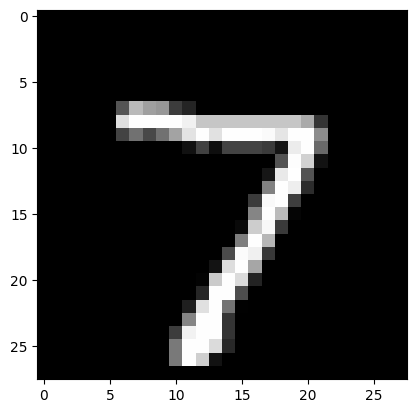

In [10]:
# Pass the single test image through the model and get the prediction

def predict_single_image(image, model):
    model.eval()
    with torch.no_grad():
        image = image.to(device)
        image = image.unsqueeze(0)  # Add batch dimension
        output = model(image)
        _, predicted = torch.max(output.data, 1)
        return predicted.item()
    
# Get a single test image
image, label = mnist_testset_no_zero[0]
plt.imshow(image.squeeze(), cmap='gray')